# 1. Importing Packages


In [84]:
import os
import requests
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json


# 2. Pulling Data from FRED API for first three series 




In [85]:
def pullFREDdata(series_id: str):
    
    """
    Pulls data from FRED API 
    accepts arguments series_ID and user's APIkey as arguments
    returns a pandas dataframe with date and series_ID values as columns
    """

    # Load in the environment variables

    path_to_dotenv = find_dotenv('.env') # NOTE: You will likely not need to do this
    load_dotenv(path_to_dotenv) # NOTE: This often works without any arguments -- try that first

    apikey = os.environ.get("Name_of_api_key_env_variable", None) # Returns None if there is no variable with that name
    
#     payload = {'series ID': series_id, 
#                 'observation_start' : '2000-01-01',
#                 'observation_end' : '2020-12-31'
#               }
    
 
    
    APIurl = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&observation_start=2000-01-01&observation_end=2020-12-31&api_key={apikey}&file_type=json'
    pulled_data = requests.get(APIurl)
    data_series_id = pulled_data.json()

    #used one of my favorite websites for data science: https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
    df_series_id = pd.json_normalize(data_series_id, record_path = ['observations']) #normalizes data 
    
    df_modified = df_series_id.drop(columns = ['realtime_start', 'realtime_end']) #removes the columns realtime_start and realtime_end since they aren't needed

    df_renamed = df_modified.rename(columns = {'value': str(series_id_dict[series_id])}) #renames the columns from series ID to actual english name
    
    df_renamed[series_id_dict[series_id]] = pd.to_numeric(df_renamed[series_id_dict[series_id]])  #converts the data to numeric data

    
    #df3 = df_renamed.fillna(value = df_renamed[series_id_dict[series_id]].mean()) #replaces nan values with the mean of the column

    return df_renamed
    
#     if df_renamed[str(series_id_dict[series_id])].isnull().sum().sum() == 0:  #checks to see if the sum of n/a values is zero 
#         return df_renamed
    
#     else:                                        #if the sum of n/a values is greater than zero, replace with mean
#         df_renamed[str(series_id_dict[series_id])] = df_renamed[str(series_id_dict[series_id])].interpolate(method = linear)  #of previous and forward value
#         return df_renamed





# 3. Merge the pulled data of each FRED series into one Pandas Dataframe

In [86]:
series_id_list = ['GDPC1', 'PAYEMS', 'CPIAUCSL', 'CSUSHPINSA','LXXRSA'] 

series_id_dict = {'GDPC1': 'Quarterly Real GDP', 
                  'PAYEMS': 'Quarterly Total Nonfarm Employment', 
                  'CPIAUCSL':'Quarterly CPI',
                  'CSUSHPINSA': 'S&P/Case-Shiller U.S. National Home Price Index' ,
                  'LXXRSA': 'S&P/Case-Shiller CA-Los Angeles Home Price Index'}

df_merged = pd.merge(pullFREDdata('CPIAUCSL'), 
                      pullFREDdata('GDPC1'), 
                      on = 'date', 
                      how = 'outer')

df_merged_final = pd.merge(df_merged, 
                            pullFREDdata('PAYEMS'), 
                            on = 'date', 
                            how = 'outer')


df_merged_final  #final pandas dataframe with columns: date, Quarterly CPI, Quarterly Real GDP, and Quarterly Total Nonfarm employment from 2000-01-01 to 2020-12-31




,date,Quarterly CPI,Quarterly Real GDP,Quarterly Total Nonfarm Employment
0,2000-01-01,169.300,12935.252,131005
1,2000-02-01,170.000,NaN,131124
2,2000-03-01,171.000,NaN,131596
3,2000-04-01,170.900,13170.749,131888
4,2000-05-01,171.200,NaN,132105
...,...,...,...,...
247,2020-08-01,259.511,NaN,141149
248,2020-09-01,260.149,NaN,141865
249,2020-10-01,260.462,18767.778,142545
250,2020-11-01,260.927,NaN,142809


# 4. Saving our Dataframe as a CSV file and double checking the tabular data is correctly formatted

In [87]:
   
csv = df_merged_final.to_csv('Lowe_project_filtered_data.csv', index = False) #saves our merged dataframe as a csv

df_saved_file = pd.read_csv('Lowe_project_filtered_data.csv')  #reading our csv file to make sure its correctly formatted
df_saved_file




,date,Quarterly CPI,Quarterly Real GDP,Quarterly Total Nonfarm Employment
0,2000-01-01,169.300,12935.252,131005
1,2000-02-01,170.000,NaN,131124
2,2000-03-01,171.000,NaN,131596
3,2000-04-01,170.900,13170.749,131888
4,2000-05-01,171.200,NaN,132105
...,...,...,...,...
247,2020-08-01,259.511,NaN,141149
248,2020-09-01,260.149,NaN,141865
249,2020-10-01,260.462,18767.778,142545
250,2020-11-01,260.927,NaN,142809


# 5. Plotting data:

        1. Adjust the dimensions of the graphs
        2. Time series graph of all three series overlayed
        3. Scatterplot of two series
        4. Histogram of one series 

**1. Adjusting the plot parameters to 8 inches wide by 4 inches high**



In [88]:
plt.rcParams['figure.figsize'] = (8, 5)

**2. Time Series Graph of all three series Overlayed**

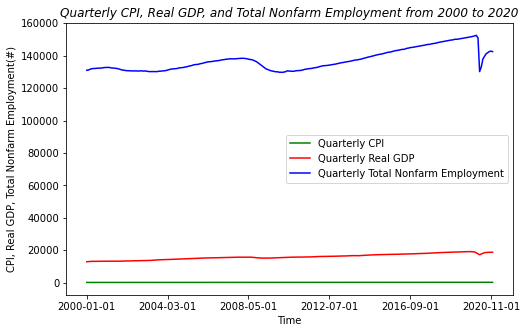

In [89]:
#Since Quarterly Real GDP has nan values, we use the interpolate method to replace these nan values with the 
#average of the values that follow and preceed the nan value

df_saved_file['Quarterly Real GDP'] = df_saved_file['Quarterly Real GDP'].interpolate(method = 'linear', limit = 3)
fig1, ax1 = plt.subplots()
df_saved_file.plot(x = 'date',         #date values for the x axis
                   y = ['Quarterly CPI','Quarterly Real GDP','Quarterly Total Nonfarm Employment' ],  #all three series on the y
                   ax = ax1,
                   color = ['green', 'red', 'blue'])



# fig2, ax2 = plt.subplots()
# df_saved_file.plot(x = 'date',         #date values for the x axis
#                    y = ['Quarterly Real GDP'],  #all three series on the y
#                    ax = ax2,
#                    color = ['green', 'red', 'blue'])
# df

plt.xlabel('Time')
plt.ylabel('CPI, Real GDP, Total Nonfarm Employment(#)')
plt.title('Quarterly CPI, Real GDP, and Total Nonfarm Employment from 2000 to 2020', style = 'italic')
plt.legend(loc = 'best')
plt.savefig('3timeseries.png')




Since Nonfarm employment has values in the 100s of thousands, Real GDP has values in the 10s of thousands and CPI has values in the hundreds, an overlay of these three series does not reflect the best trends of these series from 2000 to 2020. As a result, I have graphed each one individually below: 

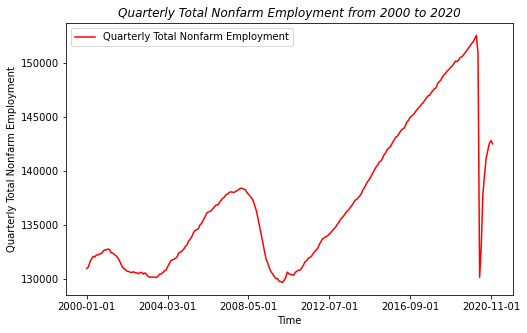

<Figure size 576x360 with 0 Axes>

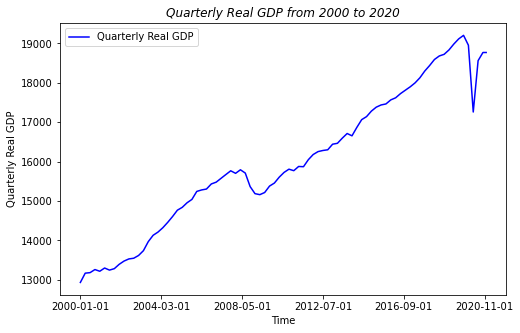

<Figure size 576x360 with 0 Axes>

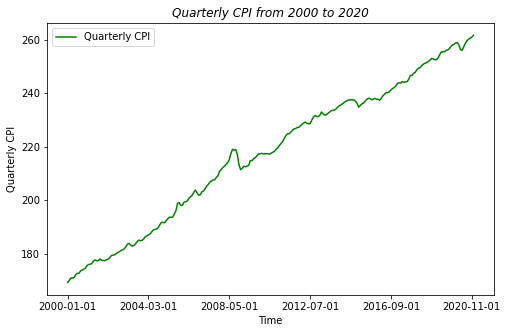

<Figure size 576x360 with 0 Axes>

In [90]:
def plotTimeSeries(series_id: str, color = str):
    
    df_saved_file[series_id_dict[series_id]] = df_saved_file[series_id_dict[series_id]].interpolate(method = 'linear', limit = 3)
    fig1, ax1 = plt.subplots()
    df_saved_file.plot(x = 'date',         #date values for the x axis
                   y = [series_id_dict[series_id]],  #all three series on the y
                   ax = ax1,
                   color = color)
    plt.xlabel('Time')
    plt.ylabel(series_id_dict[series_id])
    plt.title(f'{series_id_dict[series_id]} from 2000 to 2020', style = 'italic')
    plt.legend(loc = 'best')
    plt.plot()
    plt.show()
    plt.savefig(f'{series_id}timeSeries.png')

plotTimeSeries('PAYEMS', 'red')
plotTimeSeries('GDPC1', 'blue')
plotTimeSeries('CPIAUCSL', 'green')

**3. Scatterplots of Two Series**

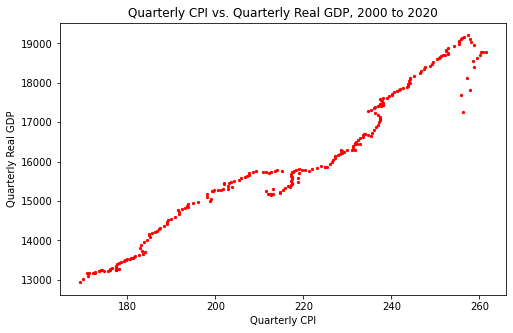

In [91]:
#3. Scatter plot

df_saved_file.plot.scatter(x = 'Quarterly CPI',          # x-axis is Quarterly CPI
                           y = 'Quarterly Real GDP',      #y axis is Quarterly Real GDP
                           marker = '.', 
                           color = 'red')                  #Plot in red 


plt.title('Quarterly CPI vs. Quarterly Real GDP, 2000 to 2020')
plt.savefig('CPIversusGDP.png')
plt.savefig('CPIversusGDP1.png', transparent = True)

# df_saved_file.plot.scatter(x = 'Quarterly Total Nonfarm Employment', y = 'Quarterly Real GDP', marker = '.', color = 'green')
# plt.title('Quarterly Total Nonfarm Employment vs. Quarterly Real GDP, 2000 to 2020')
# plt.savefig('PAYEMSversusGDP.png')
# plt.savefig('PAYEMSversusGDP1.png', transparent = True)

**4. Histogram of one series**

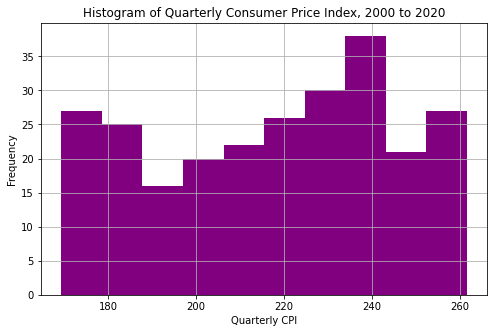

In [92]:
#histogram

df_saved_file['Quarterly CPI'].hist(color = 'purple') #plots histogram of Quarterly CPI
plt.xlabel('Quarterly CPI')
plt.ylabel('Frequency')
plt.title('Histogram of Quarterly Consumer Price Index, 2000 to 2020')
plt.savefig('QuarterlyCPIhistogram.png')  #saves the histogram as a png file




# 6. Pulling data for two more series of my choosing

I chose to compare data from the S&P/Case Shiller U.S. National Home Price Index to the S&P/Case Shiller Los Angeles, CA Home Price Index. 

In [93]:
# pullFREDdata('QTAXTOTALQTAXCAT3CANO', FRED_key)
# pullFREDdata('USFIRE', FRED_key)


df_final = pd.merge(pullFREDdata('CSUSHPINSA'),    #merges the US national Home Price Index dataframe
                    pullFREDdata('LXXRSA'),        #with the LA Home Price index dataframe
                    on = 'date',                             #both dataframes have the same dates column
                    how = 'outer')                     # merge adds the LA HPI dataframe on the outside (outer join) 
                                                       #without adding the same date column
df_final
# df_final['date'] = pd.to_datetime(df_final['date'])  #converts dates to datetime values rather than just strings
# df_final['date'] 

,date,S&P/Case-Shiller U.S. National Home Price Index,S&P/Case-Shiller CA-Los Angeles Home Price Index
0,2000-01-01,100.000,101.031209
1,2000-02-01,100.571,102.043406
2,2000-03-01,101.466,103.224699
3,2000-04-01,102.540,104.159399
4,2000-05-01,103.701,104.924698
...,...,...,...
247,2020-08-01,224.162,304.173140
248,2020-09-01,226.917,308.557136
249,2020-10-01,229.929,312.437422
250,2020-11-01,232.439,315.998825


# 7. read csv of new pulled data

In [94]:
csv2 = df_final.to_csv('two_more_series_data.csv', index = False)  #saving this second dataset to a csv file
df = pd.read_csv('two_more_series_data.csv')                      #reading this saved csv file and storing it in 
                                                                  #in a variable for plotting
df


,date,S&P/Case-Shiller U.S. National Home Price Index,S&P/Case-Shiller CA-Los Angeles Home Price Index
0,2000-01-01,100.000,101.031209
1,2000-02-01,100.571,102.043406
2,2000-03-01,101.466,103.224699
3,2000-04-01,102.540,104.159399
4,2000-05-01,103.701,104.924698
...,...,...,...
247,2020-08-01,224.162,304.173140
248,2020-09-01,226.917,308.557136
249,2020-10-01,229.929,312.437422
250,2020-11-01,232.439,315.998825


# 8. Plot Last two series
    1. Plot the two series against eachother in a scatter plot
                            or                           
    2. together as a time series plot

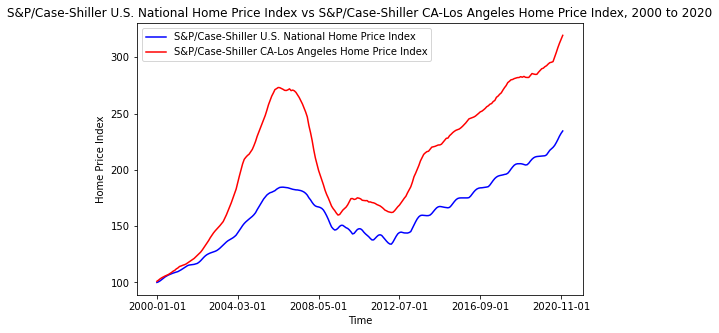

In [95]:
#Time Series Plot


fig1, ax1 = plt.subplots()
df.plot(x = 'date',                                                            #date values used for x axis
        y = ['S&P/Case-Shiller U.S. National Home Price Index',                 #US HPI and LA HPI used for y axis
                        'S&P/Case-Shiller CA-Los Angeles Home Price Index'],   
        ax = ax1,
        color = ['blue', 'red']                                               #US HPI in blue and LA HPI in red
       )                                  

plt.xlabel('Time')                      #X-axis labeled as Time
plt.ylabel('Home Price Index')          #Y- axis labeled as Home Price Index 
plt.title('S&P/Case-Shiller U.S. National Home Price Index vs S&P/Case-Shiller CA-Los Angeles Home Price Index, 2000 to 2020')
ax1.legend(loc='best')         #used to pick the best location for the legend
plt.savefig('US_HPIvsLA_HPI.png')    #saves the time series plot as a png file

